In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

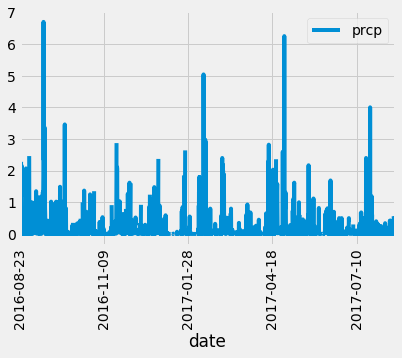

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prev_year = dt.date(2017,8,23)-dt.timedelta(days=365)
# Calculate the date 1 year ago from the last data point in the database
prev_year
# Perform a query to retrieve the data and precipitation scores
pcrp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(pcrp_data, columns = ['date', 'prcp'])
# Sort the dataframe by date
prcp_df = prcp_df.set_index(['date'])
prcp_df = prcp_df.sort_index()
prcp_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot = 90)

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).all()
print(station_count)

[(9,)]


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
find_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                            filter(Measurement.station == 'USC00519281').all()
find_temps

[(54.0, 85.0, 71.66378066378067)]

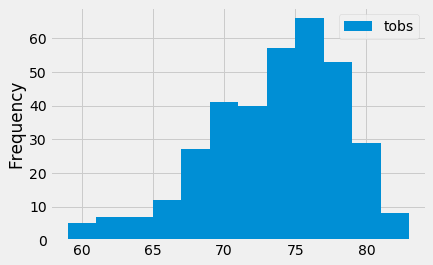

In [17]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date >= prev_year).all()
tempstat_df = pd.DataFrame(temp_station, columns = ['tobs'])
tempstat_df.plot.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min,avg,max = calc_temps('2014-01-01', '2014-01-08')[0]
print(min,avg,max)

60.0 68.77049180327869 77.0


[]

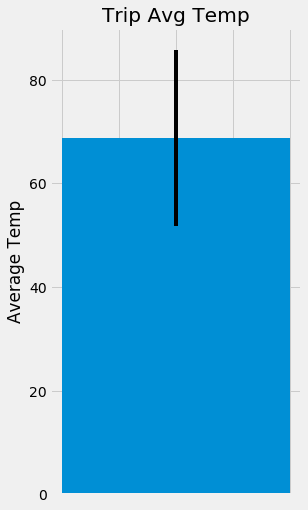

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
bar = ax.bar(1,avg,yerr = max-min, align = 'center')
ax.set(title = "Trip Avg Temp", ylabel = "Average Temp")
ax.set_xticklabels([])

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date ='2014-01-01' 
end_date = '2014-01-08'
total_rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                          filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.name).\
                           order_by(func.sum(Measurement.prcp).desc()).all()
total_rain

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.5300000000000002),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.82),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.75),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  1.35),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.31),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.76),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.63),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.35),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  None)]

In [29]:
output = session.query(Station.station).all()

In [40]:
from flask import Flask, jsonify

app = Flask(__name__)

@app.route("/")
def home():
    return "All Routes Available:"

@app.route("/api/v1.0/precipitation")
def precipitation():
    new_data = {}
    for date, prcp in pcrp_data:
        data_dict = {}
        data_dict['date'] = date
        data_dict['prcp'] = prcp
        new_data.update({date: prcp})
    
    return jsonify(new_data)

@app.route("/api/v1.0/stations")
def stations():
    output = session.query(Station.station).all()
    outputs = list(np.ravel(output))
    return jsonify(outputs)

@app.route("/api/v1.0/tobs")
def temp():
    temp_output = list(np.ravel(temp_station))
    return jsonify(temp_output)

# @app.route("/api/v1.0/<start>")
# def start():

# @app.route("/api/v1.0/temp/<start>")
# def test():
# #     start = '%Y-%m-%d'
#     results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#             filter(Measurement.date >= start).all()
#     results1 = list(np.ravel(results))
#     return jsonify(results1)
# @app.route("/api/v1.0/temp/<start>/<end>")
# def stats(start=None, end=None):
#     """Return TMIN, TAVG, TMAX."""
#     # Select statement
# #     sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
#     if not end:
#         # calculate TMIN, TAVG, TMAX for dates greater than start
#         results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#             filter(Measurement.date >= start).all()
#         # Unravel results into a 1D array and convert to a list
#         temps = list(np.ravel(results))
#         return jsonify(temps)
#     # calculate TMIN, TAVG, TMAX with start and stop
#     results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#         filter(Measurement.date >= start).\
#         filter(Measurement.date <= end).all()
#     # Unravel results into a 1D array and convert to a list
#     temps = list(np.ravel(results))
#     return jsonify(temps)

@app.route("/api/v1.0/start")
def temp_results():
    results = calc_temps('2012-02-28', '2012-03-05')
    return results

if __name__ == '__main__':
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Feb/2020 20:48:25] "GET / HTTP/1.1" 200 -
[2020-02-15 20:48:33,351] ERROR in app: Exception on /api/v1.0/start [GET]
Traceback (most recent call last):
  File "C:\Users\13862\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\engine\base.py", line 1173, in _execute_context
    context = constructor(dialect, self, conn, *args)
  File "C:\Users\13862\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\engine\default.py", line 775, in _init_compiled
    self.cursor = self.create_cursor()
  File "C:\Users\13862\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\engine\default.py", line 1131, in create_cursor
    return self._dbapi_connection.cursor()
  File "C:\Users\13862\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\sqlalchemy\pool\base.py", line 978, in cursor
    return self.connection.cursor(*args, **kwar

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


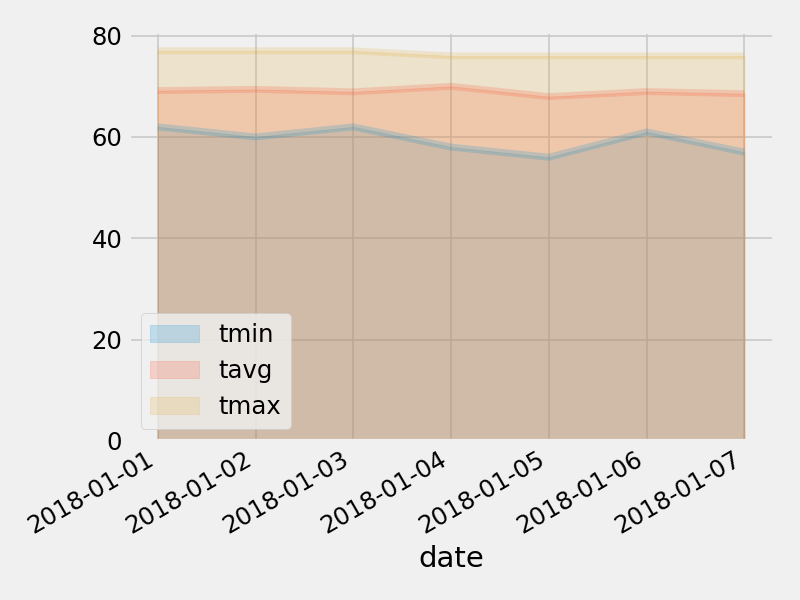

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
